# Analysis of results taken from the experimental framework


Analysis needs to answer three specific questions that standard ML metrics don't cover: TODO: WHY?

- Reliability: Can the model write valid code? (Syntax).

- Accuracy: Does the code actually catch the rule violations? (Logic).

- Stability: Does it solve the problem the same way every time? (Determinism).

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap


In [22]:
# Load Data
df = pd.read_csv("Master_Results.csv")

df['Count_Error'] = (df['Actual Violation Count'] - df['Expected Violation Count']).abs()
df['Count_Bias'] = df['Actual Violation Count'] - df['Expected Violation Count']
df['Strict_Match'] = df['Actual Violation Count'] == df['Expected Violation Count']


In [23]:
# Tally (temporary)

# Group by the configuration columns and count unique Run IDs 
# (Since rows are repeated per scenario, we use nunique to get the actual number of pipeline executions)
summary = df.groupby(["Document Name", "Prompts", "Model Name"])["Run ID"].nunique()
print(f"--- Completed Runs per Configuration ---")
for (doc, prompt, model), count in summary.items():
    print(f"{doc} | {prompt} | {model} : {count}")


--- Completed Runs per Configuration ---
parental_leave | Default | gemini-2.5-flash : 20
parental_leave | Default | gemini-2.5-pro : 10
parental_leave | Reflexion | gemini-2.5-flash : 16
parental_leave | ZeroShot | gemini-2.5-flash : 20
parental_leave | ZeroShot | gemini-2.5-pro : 10
student_housing | Default | gemini-2.5-flash : 20
student_housing | Default | gemini-2.5-pro : 10
student_housing | Reflexion | gemini-2.5-flash : 20
student_housing | Reflexion | gemini-2.5-pro : 10
student_housing | ZeroShot | gemini-2.5-flash : 20
student_housing | ZeroShot | gemini-2.5-pro : 10


load the "Tidy Data" (Long Format) and create a "Wide Format" version for run-level statistics.

In [24]:
# 1. Create a "Run-Level" Aggregate with Metadata preserved
# We group by ALL the identifier columns so they stay in the result
group_cols = ['Run ID', 'Document Name', 'Model Name', 'Prompts']

run_stats = df.groupby(group_cols).agg({
    # Artifact Metrics
    "SHACL Valid Syntax": "first",     # Constant per run
    "SHACL Graph Hash": "first",       # Constant per run
    "SHACL Error Type": "first",       # Constant per run
    "Execution Time": "max",           # Max time recorded (or first, if consistent)
    
    # Average the error metrics
    'Count_Error': 'mean',      # Mean Absolute Error (MAE) for this run
    'Strict_Match': 'mean',     # % of scenarios where count was EXACT
}).reset_index()

# Display to verify headers exist
print("Columns available for plotting:", run_stats.columns.tolist())
display(run_stats)

Columns available for plotting: ['Run ID', 'Document Name', 'Model Name', 'Prompts', 'SHACL Valid Syntax', 'SHACL Graph Hash', 'SHACL Error Type', 'Execution Time', 'Count_Error', 'Strict_Match']


,Run ID,Document Name,Model Name,Prompts,SHACL Valid Syntax,SHACL Graph Hash,SHACL Error Type,Execution Time,Count_Error,Strict_Match
0,1,student_housing,gemini-2.5-pro,Default,True,12c3549e706983be87cc41bf7db3f344,VALID,134.0,0.181818,0.818182
1,2,student_housing,gemini-2.5-pro,Default,True,6fbf277aef148834d9e6f93bdd39fe7b,VALID,111.0,0.000000,1.000000
2,3,student_housing,gemini-2.5-pro,Default,False,40bfe8291d05a84b4b50e5ffd26b2b61,SPARQL_SYNTAX,136.0,NaN,0.000000
3,4,student_housing,gemini-2.5-pro,Default,False,389c6e7083760b62714f1195deb39b52,SPARQL_SYNTAX,117.0,NaN,0.000000
4,5,student_housing,gemini-2.5-pro,Default,True,fe87cddac52ce6f8e869f29fef0caa94,VALID,118.0,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...
161,162,parental_leave,gemini-2.5-flash,Reflexion,True,b52bdb57ad7cb975bf195e97061bcaea,VALID,110.0,0.000000,1.000000
162,163,parental_leave,gemini-2.5-flash,Reflexion,True,8bdcb88696e8380151fad453d3309bd4,VALID,71.0,0.000000,1.000000
163,164,parental_leave,gemini-2.5-flash,Reflexion,False,b3ef1a2f504c6936102fa9022b3dd121,SPARQL_SYNTAX,93.0,NaN,0.000000
164,165,parental_leave,gemini-2.5-flash,Reflexion,True,7f60400744ebcdaffca9622be29d0d96,VALID,100.0,0.200000,0.800000


## Syntax Metrics

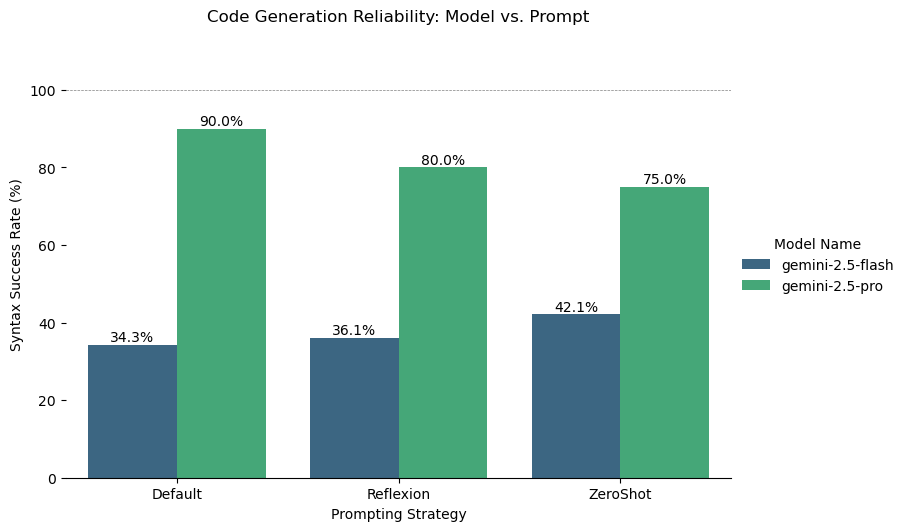

In [25]:
# 1. Prepare Data: Calculate Percentage of Valid Syntax per Model & Prompt
# Group by Configuration
validity_stats = run_stats.groupby(['Model Name', 'Prompts'])['SHACL Valid Syntax'].value_counts(normalize=True).rename('Percentage').reset_index()

# Convert to % for readability
validity_stats['Percentage'] = validity_stats['Percentage'] * 100

# Filter to show only the "True" (Valid) rate
success_rates = validity_stats[validity_stats['SHACL Valid Syntax'] == True]

# 2. Plot
g = sns.catplot(
    data=success_rates,
    kind="bar",
    x="Prompts",
    y="Percentage",
    hue="Model Name",
    palette="viridis",
    height=5, 
    aspect=1.5,
    errorbar=None
)

g.despine(left=True)
g.set_axis_labels("Prompting Strategy", "Syntax Success Rate (%)")
plt.title("Code Generation Reliability: Model vs. Prompt", y=1.05)
plt.axhline(100, color='grey', linestyle='--', linewidth=0.5) # Perfect line
plt.ylim(0, 110) # Give room for labels

# Optional: Add value labels on bars
for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%')

plt.show()

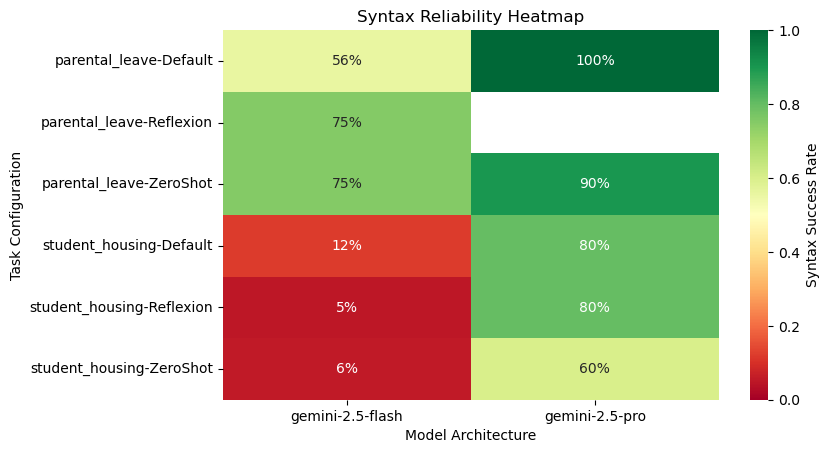

In [26]:
# 1. Force Type Conversion BEFORE Pivoting
# This converts True -> 1.0, False -> 0.0, and "True" (string) -> 1.0
run_stats["SHACL Valid Syntax"] = run_stats["SHACL Valid Syntax"].astype(float)

# 2. Create the Pivot Table
# We use "Prompts" instead of "Prompt Version"
heatmap_data = run_stats.pivot_table(
    index=["Document Name", "Prompts"], 
    columns="Model Name", 
    values="SHACL Valid Syntax", 
    aggfunc="mean" # Now guarantees a float result
)

# 3. Fill NaNs (Optional but recommended)
# If a specific combo (e.g., Flash + Naive) was never run, it produces NaN.
# You can leave it grey (default) or fill with 0.
# heatmap_data = heatmap_data.fillna(0)

# 4. Plot
plt.figure(figsize=(8, max(4, len(heatmap_data) * 0.8))) # Prevent tiny squished charts
sns.heatmap(
    heatmap_data, 
    annot=True, 
    fmt=".0%", # Displays 1.0 as 100%
    cmap="RdYlGn", 
    vmin=0, 
    vmax=1,
    cbar_kws={'label': 'Syntax Success Rate'}
)

plt.title("Syntax Reliability Heatmap")
plt.xlabel("Model Architecture")
plt.ylabel("Task Configuration")
plt.show()

## Logic Metrics

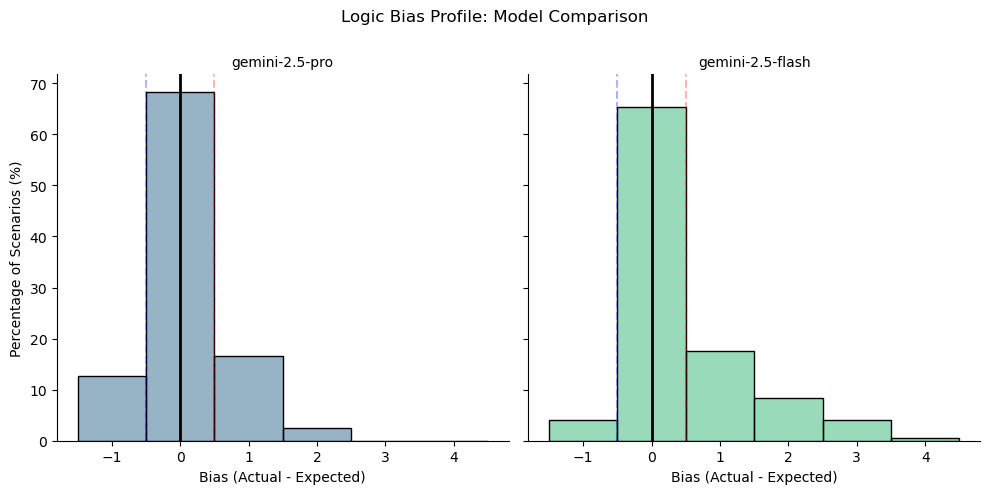

In [27]:
# 1. Prepare Data
valid_runs_df = df[df["SHACL Valid Syntax"] == True].copy()
valid_runs_df['Count_Bias'] = valid_runs_df['Actual Violation Count'] - valid_runs_df['Expected Violation Count']

# 2. Plot: Faceted Histogram
g = sns.displot(
    data=valid_runs_df,
    x="Count_Bias",
    col="Model Name",      # Separate chart for each model
    kind="hist",
    stat="percent",        # Normalize to 0-100%
    common_norm=False,     # Calculate % relative to each model's total runs
    discrete=True,         # Center bars on integers (-1, 0, 1)
    element="bars",
    hue="Model Name",      # Color code by model for visual distinction
    legend=False,          # Hide legend (redundant with titles)
    palette="viridis",
    height=5,
    aspect=1
)

# 3. Add Context Lines
def add_reference_lines(x, **kwargs):
    plt.axvline(x=0, color='black', linestyle='-', linewidth=2, label="Perfect Logic")
    plt.axvline(x=0.5, color='red', linestyle='--', alpha=0.3, label="Over-Strict")
    plt.axvline(x=-0.5, color='blue', linestyle='--', alpha=0.3, label="Too Lenient")

g.map(add_reference_lines, "Count_Bias")

# 4. Styling
g.set_axis_labels("Bias (Actual - Expected)", "Percentage of Scenarios (%)")
g.set_titles("{col_name}") # Clean titles
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Logic Bias Profile: Model Comparison")

plt.show()

--- Analysis for Document: student_housing ---


C:\Users\Nicklamda\AppData\Local\Temp\ipykernel_10012\652803454.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_yticklabels([textwrap.fill(e.get_text(), 60) for e in chart.get_yticklabels()])


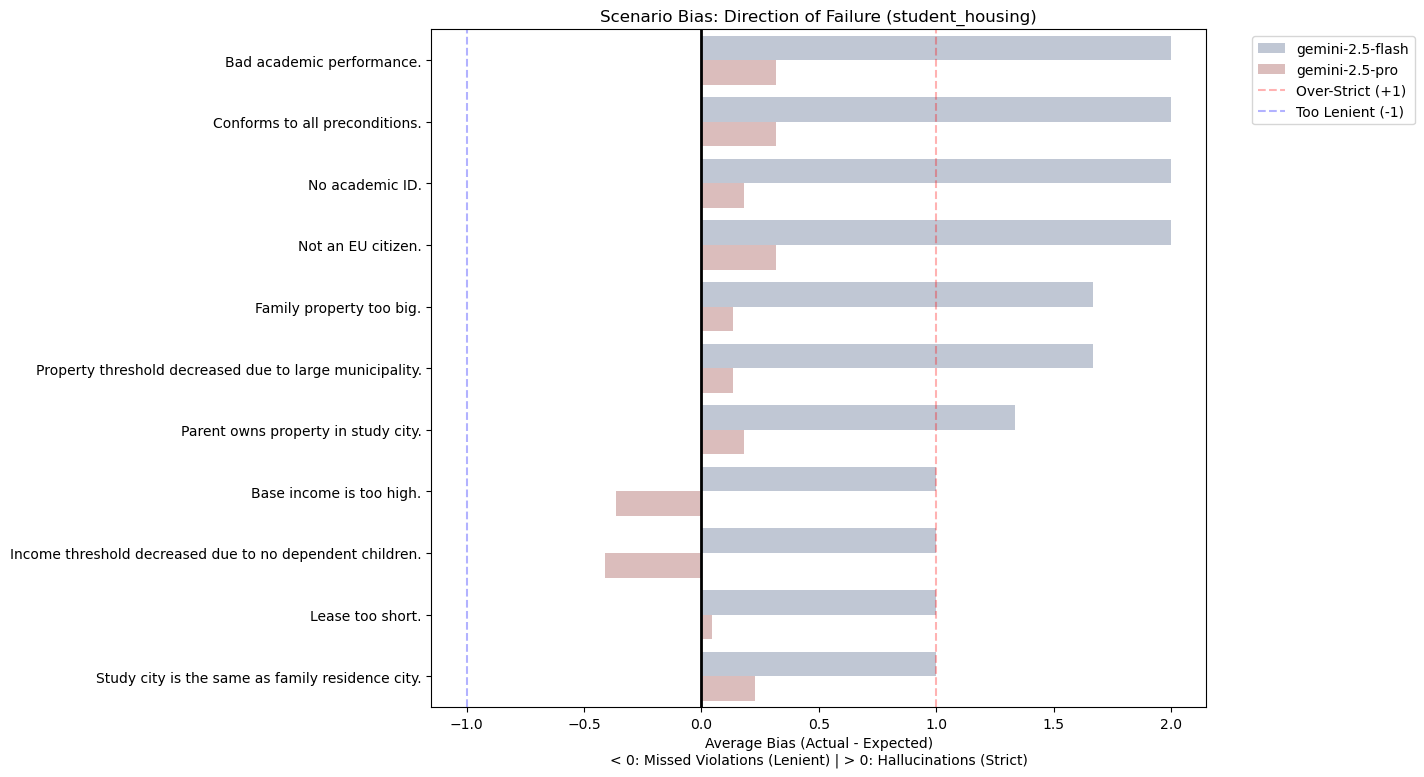

--- Analysis for Document: parental_leave ---


C:\Users\Nicklamda\AppData\Local\Temp\ipykernel_10012\652803454.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_yticklabels([textwrap.fill(e.get_text(), 60) for e in chart.get_yticklabels()])


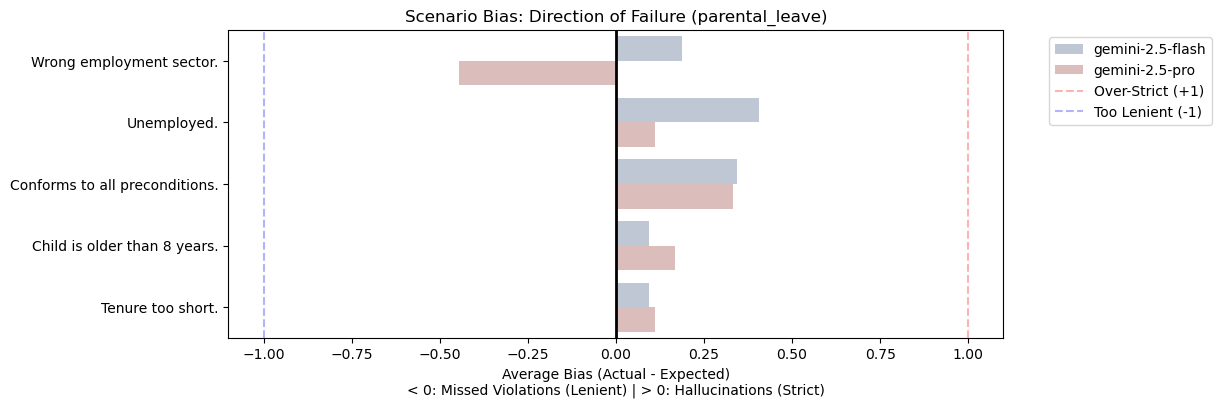

In [28]:
# 1. Filter Valid Runs
valid_ids = run_stats[run_stats["SHACL Valid Syntax"] == True]["Run ID"]
scenario_df = df[df["Run ID"].isin(valid_ids)].copy()

# 2. Calculate Bias Row-Wise
scenario_df['Count_Bias'] = scenario_df['Actual Violation Count'] - scenario_df['Expected Violation Count']

# 3. Iterate per Document
unique_docs = scenario_df["Document Name"].unique()

for doc in unique_docs:
    print(f"--- Analysis for Document: {doc} ---")
    doc_data = scenario_df[scenario_df["Document Name"] == doc]
    
    # 4. Calculate Average BIAS per Scenario
    # Note: We group by Description and Model
    viz_data = doc_data.groupby(["Scenario Description", "Model Name"])["Count_Bias"].mean().reset_index()
    
    # SORTING TRICK: Sort by the MAGNITUDE (Absolute value) of the bias
    # This ensures big errors (positive OR negative) float to the top
    viz_data['Abs_Bias'] = viz_data['Count_Bias'].abs()
    order = viz_data.groupby("Scenario Description")["Abs_Bias"].max().sort_values(ascending=False).index
    
    # 5. Plot
    plt.figure(figsize=(10, len(order) * 0.8))
    
    chart = sns.barplot(
        data=viz_data,
        y="Scenario Description",
        x="Count_Bias", # Plotting the Signed Bias (+/-)
        hue="Model Name",
        order=order,
        palette="vlag" # Diverging palette (Blue = Negative, Red = Positive)
    )
    
    # 6. Formatting
    plt.title(f"Scenario Bias: Direction of Failure ({doc})")
    plt.xlabel("Average Bias (Actual - Expected)\n< 0: Missed Violations (Lenient) | > 0: Hallucinations (Strict)")
    plt.ylabel("") 
    
    # Center Line (Perfect)
    plt.axvline(x=0, color='black', linestyle='-', linewidth=2)
    
    # Context Lines
    plt.axvline(x=1.0, color='red', linestyle='--', alpha=0.3, label="Over-Strict (+1)")
    plt.axvline(x=-1.0, color='blue', linestyle='--', alpha=0.3, label="Too Lenient (-1)")
    
    # Wrap text
    chart.set_yticklabels([textwrap.fill(e.get_text(), 60) for e in chart.get_yticklabels()])
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

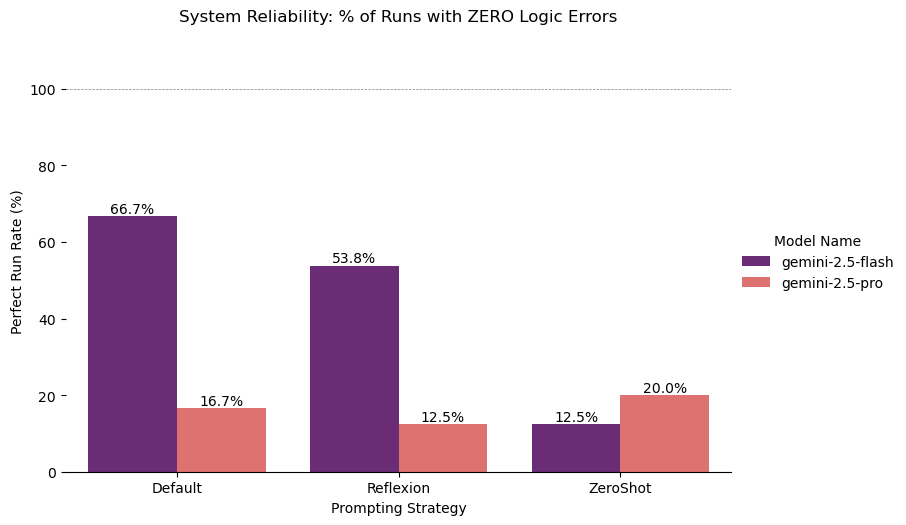

In [29]:
# 1. Filter Valid Syntax runs only
valid_runs_df = df[df["SHACL Valid Syntax"] == True].copy()

# 2. Determine "Perfection" per Run
# Group by Run ID. A run is perfect ONLY if .all() scenarios are Strict Matches.
run_outcomes = valid_runs_df.groupby(['Run ID', 'Model Name', 'Prompts'])['Strict_Match'].all().reset_index()
run_outcomes.rename(columns={'Strict_Match': 'Is_Perfect_Run'}, inplace=True)

# 3. Calculate Percentage of Perfect Runs per Model/Prompt
# Mean of True/False (1/0) gives the percentage.
perfection_stats = run_outcomes.groupby(['Model Name', 'Prompts'])['Is_Perfect_Run'].mean().reset_index()
perfection_stats['Percentage'] = perfection_stats['Is_Perfect_Run'] * 100

# 4. Plot
g = sns.catplot(
    data=perfection_stats,
    kind="bar",
    x="Prompts",
    y="Percentage",
    hue="Model Name",
    palette="magma",
    height=5, 
    aspect=1.5
)

# 5. Formatting
g.despine(left=True)
g.set_axis_labels("Prompting Strategy", "Perfect Run Rate (%)")
plt.title("System Reliability: % of Runs with ZERO Logic Errors", y=1.05)
plt.axhline(100, color='grey', linestyle='--', linewidth=0.5)
plt.ylim(0, 110)

# Add Labels
for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%')

plt.show()

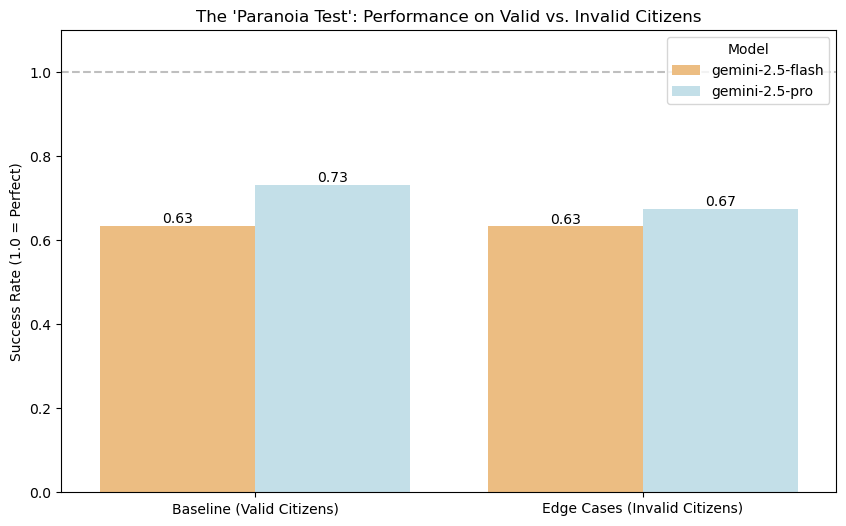

In [30]:
# 1. Filter Valid Runs
valid_ids = run_stats[run_stats["SHACL Valid Syntax"] == True]["Run ID"]
scenario_df = df[df["Run ID"].isin(valid_ids)].copy()

# 2. Tag Scenarios as "Baseline" (Innocent) or "Edge Case" (Guilty)
def categorize_scenario(expected_count):
    if expected_count == 0:
        return "Baseline (Valid Citizens)"
    else:
        return "Edge Cases (Invalid Citizens)"

scenario_df['Scenario_Type'] = scenario_df['Expected Violation Count'].apply(categorize_scenario)

# 3. Calculate Success Rate (Strict Match) for each group
# Strict Match means: Actual Count == Expected Count
grouped_stats = scenario_df.groupby(['Model Name', 'Scenario_Type'])['Strict_Match'].mean().reset_index()

# 4. Plot
plt.figure(figsize=(10, 6))

chart = sns.barplot(
    data=grouped_stats,
    x="Scenario_Type",
    y="Strict_Match",
    hue="Model Name",
    palette="RdYlBu"
)

# 5. Formatting
plt.title("The 'Paranoia Test': Performance on Valid vs. Invalid Citizens")
plt.ylabel("Success Rate (1.0 = Perfect)")
plt.xlabel("")
plt.ylim(0, 1.1)
plt.axhline(y=1.0, color='grey', linestyle='--', alpha=0.5)

# Add labels
for container in chart.containers:
    chart.bar_label(container, fmt='%.2f')

plt.legend(title="Model")
plt.show()